<p style="font-size:30px; text-align:center"><b>Local Regression</b></p>
<div style="text-align: right">(C) Nikolai Nowaczyk, <a href="https://github.com/Lapsilago">Jörg Kienitz</a> 2021</div>

Local regression is a powerful enhancement of linear regression, which refines predictions by tailoring the hypothesis to each point of the prediction. In this notebook, we derive the mathematical framework, illustrate its practical use with some examples and compare with conventional linear regression.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from locreg import LocalRegression # supplied with library folder
import ipywidgets as wdg

In [4]:
%matplotlib notebook
# uncomment to support dark themes
# plt.style.use(['dark_background'])

# Linear Regression

In linear regression we are given a labelled data set $(x_i, y_i)$, $i=1, \ldots, N$, $x_i \in \mathbb{R}^d$, $y_i \in \mathbb{R}$, and we assume that they are related via
\begin{align*}
    y_i = f(x_i) + \varepsilon_i,
\end{align*}
where $\varepsilon_i$ is a realization of a centered iid random variable called the *noise* and $f:\mathbb{R}^d \to \mathbb{R}$ is a measurable function. Both, $f$ and $\varepsilon_i$ are not known in practice. However, we will want to make predictions $f(x)$ for $x \in \mathbb{R}^d$.

The idea of linear regression is to first extract potentially new features out of the input data by means of a feature map $\Phi:\mathbb{R}^d \to \mathbb{R}^k$, and then assume that the $\Phi(x_i)$ are linearly related to the $y_i$, i.e. we form the *linear hypothesis*
\begin{align*}
    f_{\beta}(x) = \Phi(x)^{\top} \beta,
\end{align*}
for some coefficient vector $\beta \in \mathbb{R}^k$. We fit the coefficients to the data by the *least squares method*, i.e. by 
\begin{align*}
    \beta^* := \operatorname{argmin}_{\beta}{\sum_{i=1}^N{\|f_{\beta}(x_i) - y_i\|_2^2}}
\end{align*}
If we collect all the inputs in the *design matrix* $X \in \mathbb{R}^{N \times k}$, $X_{ij} := \Phi_j(x_i)$, one can show that $\beta^*$ can be computed from the *normal equations*
\begin{align*}
    X^{\top}X \beta^* = X^{\top} y.
\end{align*}
Finally, new predictions can then be made by $f(x) := f_{\beta^*}(x) = \Phi(x)^{\top} \beta^*$.

## Example 1: Parabolic Fit

Let's illustrate these concepts with an easy synthetic example: We assume that the $x_i$ and $y_i$ are both scalar and that they are related by a polynomial $f$ of degree $2$.

In [5]:
x = np.linspace(-1,1,100)  # generate the $x_i$
np.random.seed(1)
e = np.random.normal(0, 0.1, 100)  # generate $\varepsilon_i$
y = x**2 + e # generate $y_i$
X = x[:,np.newaxis]  # convert to training set
poly = PolynomialFeatures(degree=2, include_bias=False) # create the features $\Phi(x_i)$
phi = poly.fit_transform(X)
reg = LinearRegression(fit_intercept=True).fit(phi,y)  # compute the fit
#phi_test = poly.fit_transform((x[1]-x[0]) / 2 + x[:, np.newaxis]) # create a test set with intermediate points

<IPython.core.display.Javascript object>


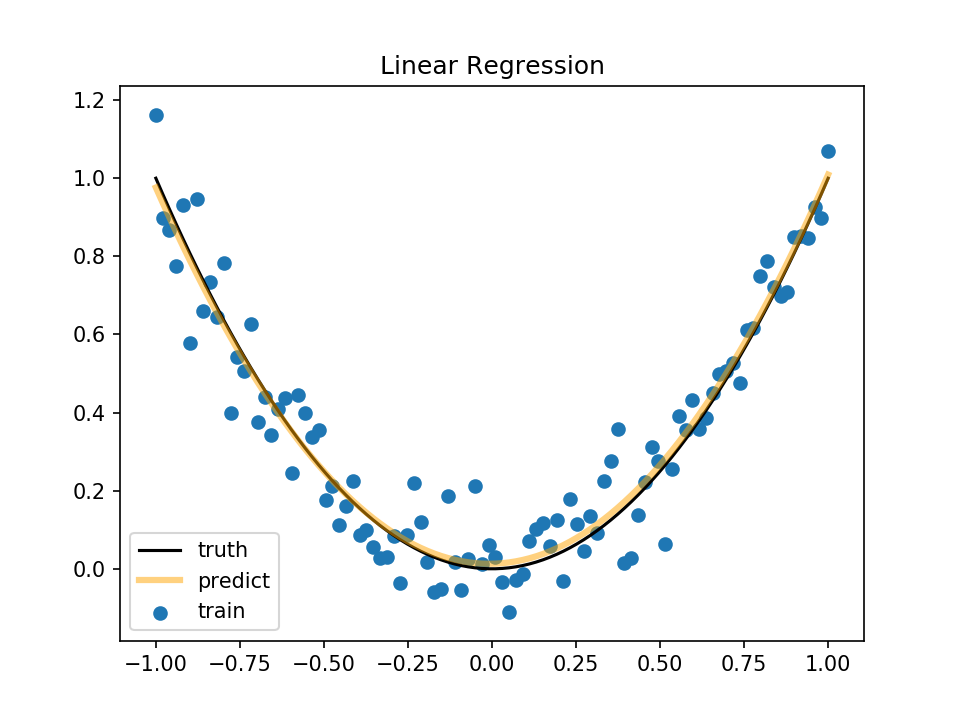

Score: 0.920228


In [6]:
plt.figure()
plt.scatter(x, y, label='train', color='tab:blue')
plt.plot(x, x**2, label='truth', color='k')
plt.plot(x, reg.predict(phi), linewidth=3, color='orange', label='predict', alpha=0.5)
#plt.plot(x, reg.predict(phi_test), linewidth=3, color='red', label='predict test', alpha=0.5)
plt.legend()
plt.title('Linear Regression')
plt.show()
print("Score: %f" % reg.score(phi, y))

**Conclusions & Remarks:** 
* We see that the global fit works very well on both the training and the test set. Unsurprisingly, the regression with polynomial features can capture the data quite well despite the added Gaussian noise. This holds in general: Whenever the underlying functional relationship $f$ is globally a polynomial of the same degree as the linear hypothesis, we usually obtain a good fit.
* While the initial global fit has a relatively high computational effort, evaluating the fitted regression on new data is quite cheap.

## Example 2: Sine Function

Now, let us consider the example $f(x)=\sin(x)$, which does not globally behave at all like a polynomial.

In [7]:
n = 250
x = np.linspace(-20, 20, n)
np.random.seed(1)
e = np.random.normal(0, 0.1, n)
y = np.sin(x) + e
X = x[:,np.newaxis]

In [8]:
lr_preds = {}
lr_scores = {}
#lr_tests = {}
d_max = 11
for d in range(1, d_max):
    poly = PolynomialFeatures(degree=d, include_bias=False) 
    phi = poly.fit_transform(X)
    reg = LinearRegression(fit_intercept=False).fit(phi,y)
    lr_preds[d] = reg.predict(phi)
    lr_scores[d] = reg.score(phi, y)
    phi_test = poly.fit_transform((x[1]-x[0]) / 2 + x[:, np.newaxis])
    #lr_tests[d] = reg.predict(phi_test)    

<IPython.core.display.Javascript object>


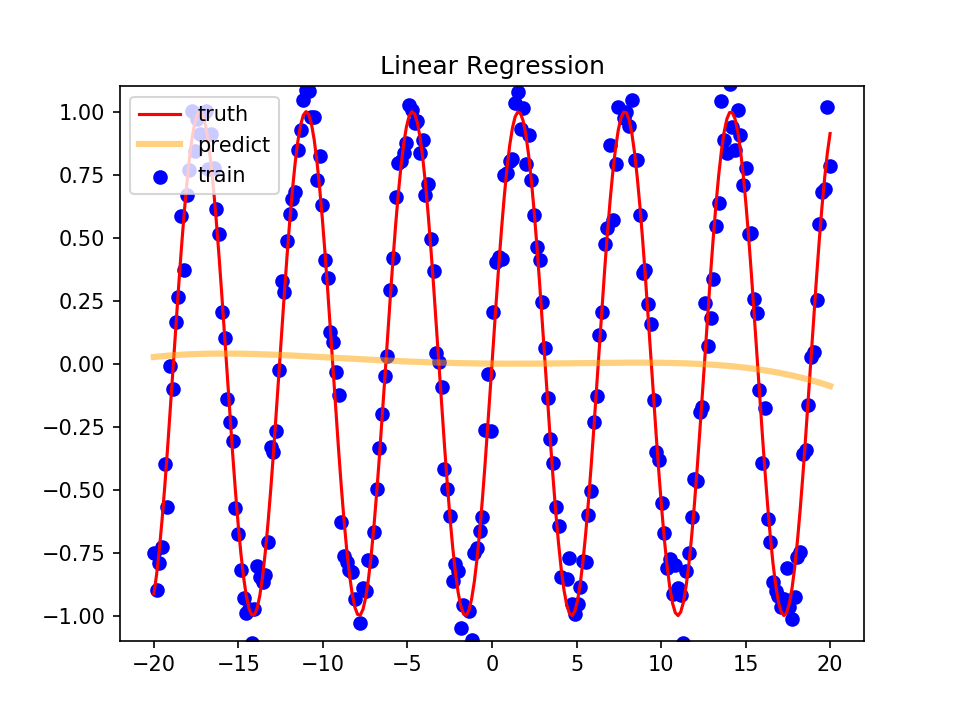

interactive(children=(IntSlider(value=4, description='d', max=10, min=1), Output()), _dom_classes=('widget-int…

In [9]:
plt.figure()

@wdg.interact()
def plot_sine(d=wdg.IntSlider(min=1, max=10, value=4)):
    plt.cla()
    plt.scatter(x, y, color='b', label='train')
    plt.plot(x, np.sin(x), color='r', label='truth')
    plt.plot(x, lr_preds[d], color='orange', linewidth=3, label='predict', alpha=0.5)
    #plt.plot(x, lr_tests[d], color='red', linewidth=3, label='predict red', alpha=0.5)
    plt.legend()
    plt.title('Linear Regression')
    plt.gca().set_ylim([-1.1, 1.1])
    print("Score: %f" % lr_scores[d])

**Conclusion:** We condlude that even with crazy high degrees, the polynomial regression does not capture the function $f(x)=\sin(x)$ very well. That is because $\sin(x)$ is not a polynomial in itself and globally not close to one. One can represent it as a power series, i.e. one can think of it as the polynomial with infinite degree
\begin{align*}
    f(x) = \sin(x) = \sum_{n=0}^{\infty}{\frac{(-1)^n}{(2n +1)!}x^{2n + 1}}.
\end{align*}

# Local Regression

## Mathematical Derivation

The idea of local regression is to acknowledge that not every function $f$ behaves gobally like a polynomial. However, if $f$ is differentiable, then $f$ behaves like a polynomial *locally*. In fact, one of the definitions of differentiability is that near a point $x$, the function $f$ can be approximated well by a line. If $f$ is differentiable of higher order, it can be approximated even better by polynomials of higher degree. The precise mathematical formulation of this is 

**Taylor's Theroem:** Let $f:U \subset \mathbb{R}^d \to \mathbb{R}$ be a function and let $f$ be differentiable at $x \in U$ of order $p$. Then the *Taylor polynomial of $f$ at $x$ of degree $p$*
\begin{align*}
    T[f; x; p](a) := \sum_{|\alpha| \leq p}{\frac{\partial^{\alpha}f(x)}{\alpha!}(a-x)^{\alpha}}
\end{align*}
has the property that the error satisfies
\begin{align*}
    f - T[f; x; p] \in \mathcal{o}(\|a-x\|^{p}), && a \to x.
\end{align*}

This means that any multivariate function $f$, which is differentiable of order $p$ can be approximated well *locally* by a polynomial of degree $p$.

This fact can be exploited for regression as follows: Assume that we are given $x_i \in \mathbb{R}^d$, $y_i \in \mathbb{R}$, $i=1, \ldots, N$ and we assume 
\begin{align*}
    y_i = f(x_i) + \varepsilon_i
\end{align*}
as above with the additional requirement that $f$ is differentiable of order $p$. Now, we want to make a prediction $f(x)$. First, we replace $f$ by its Taylor polynomial $T[f; x; p]$. The problem is that the coefficients of that polynomial require the knowledge of $\partial^{\alpha}f(x)$, which is not available as $f$ is not available. However, we can simply set $\frac{\partial^{\alpha}f(x)}{\alpha!} =:\beta_{\alpha}$ and now attempt to determine these coefficients $\beta_{\alpha}$ via least squares regression.

**Cost Functional:** The regression is set up by defining the cost functional
\begin{align*}
    J[f; x; p](\beta) &:= \sum_{i=1}^{N}{(T[f; x; p](x_i) - y_i)^2 w_i}
    = \sum_{i=1}^{N}{\Big(\beta_0 - y_i + \sum_{1 \leq |\alpha| \leq p}{\beta_\alpha(x_i-x)^{\alpha}}\Big)^2 w_i}
\end{align*}
and we determine the $\beta=(\beta_{\alpha})_{|\alpha| \leq p}$ by minimizing this cost functional. 

A few remarks are in order:
* The cost functional $J$ is obtained by expanding $f$ into its Taylor polynomial $T[f; x; p]$ and evaluating this for all the $x_i$ and compute the quadratic error to the $y_i$.
* Because Taylor's theorem asserts that $T[f; x; p]$ is a good approximation of $f$ near $x$, we have to add weights $w_i$ to the cost functional that ensure that a lot of weight is given to $x_i$'s near $x$ and little weight is given to $x_i$'s far away from $x$. One common way to choose the weights systematically is via kernel functions given below.
* Assuming we obtain a good local fit by minimizing this cost functional, we have $f(x) = T[f; x; p](x) \approx \beta_0$. This means that while for the fit all the coefficients $\beta_{\alpha}$ are needed, only $\beta_0$ is needed for the prediction.

## Choice of Weights & Kernel Function

A popular choice of weights $w_i$ is by means of a *kernel function* $K:\mathbb{R}^d \to \mathbb{R}$, the most popular one being the *exponential kernel* $K(z) = \exp(-\|z\|^2/2)$. One can scale kernel functions by a *bandwidth* $h > 0 $ via $K_h(z) := h^{-d} K(z/h)$ and for some fixed choice of $h$, one then sets the weights as
\begin{align*}
    w_i := K_h(x-x_i).
\end{align*}
This ensures that for $x_i$ close to $x$ the corresponding summand in the cost functional results in a high penalty, while for $x_i$ far away from $x$, the contribution is small.

## Choice of Bandwidth

While in theory it is possible to compute the optimal bandwidth, this is difficult in practice. A popular choice of bandwidth is [Silverman's rule of thumb](https://en.wikipedia.org/wiki/Kernel_density_estimation#A_rule-of-thumb_bandwidth_estimator)
\begin{align*}
    h := \Big(\frac{4}{3 N} \Big)^{\tfrac{1}{5}} \hat \sigma_Y,
\end{align*}
where $\hat \sigma_Y$ is the empiricial standard deviation in the $y_i$.

## Normal Equation & Analytic Solutions

Just like for linear regression, the solution $\beta^*$ of the minimization of the cost functional satisfies a normal equation: If we denote by $\Phi(x) = (x^\alpha)_{|\alpha| \leq p} \in \mathbb{R}^{m}$, $m := m(p,d) = \tfrac{1-d^p}{1-d}$, the extracted polynomial features and by $X = (\Phi(x_i))_{i=1, \ldots, N} \in \mathbb{R}^{N \times m}$ the design matrix and set $W := \operatorname{diag}(w_i)_{i=1, \ldots, N} \in \mathbb{R}^{N \times N}$, then the cost functional $J:\mathbb{R}^m \to \mathbb{R}$ can be written as
\begin{align*}
    J(\beta) = \| W^{1/2}(X \beta - y)\|_2^2
\end{align*}
and its minimum $\beta^*$ is attained at
\begin{align*}
    (W^{1/2}X)^\top W^{1/2} X \beta^* = X^T W^{1/2} W^{1/2} y
\end{align*}
Thus, as an alternative to minimizing the cost functional with an iterative method, one can also solve the normal equations, for example using a QR-decomposition. In that case, we set $Q R = A:= W^{1/2} X$, where $Q \in \mathbb{R}^{N \times N}$ is orthogonal and $R = (\bar R, 0)^\top \in \mathbb{R}^{N \times m}$ is a lower rectangular matrix and we assume that the input data allows for $\bar R \in \mathbb{R}^{m \times m}$ to be invertible. Setting $c$ to be the first $m$ entries of $W^{1/2} y$, we find that $\bar R \beta^* = c$, which can be efficiently solved using a backwards recursion scheme.

For low degrees, i.e. $p=0,1$, one can also solve the normal equations analytically. The prediction at $x$ can be computed via
\begin{align}
    \sum_{i=1}^{N}{W_i^p(x) y_i},
\end{align}
where
\begin{align*}
    W_i^0(x) := \frac{K_h(x - x_i)}{\sum_{j=1}^{N}{K_h(x-x_j)}}, &&
    W_i^1(x) := \frac{1}{N} \frac{\hat s_2(x) - \hat s_1(x)(x-x_i)}{\hat s_2(x)s_0(x)-\hat s_1(x)^2} K_h(x-x_i).
\end{align*}
Here, we denote $s_r(x) := \frac{1}{N} \sum_{i=1}^{N}{(x-x_i)^rK_h(x-x_i)}$. The case $p=0$ is called *Nadaraya-Watson regression* and $p=1$ is called *locally linear regression*.

## Example 3: Sine Function

In [10]:
locregnw = LocalRegression(degree=0).fit(X, y)
locregll = LocalRegression(degree=1).fit(X, y)
locreg_preds = {0: locregnw.predict(X),
                1: locregll.predict(X)}
locreg_scores = {0: locregnw.score(X, y),
                 1: locregll.score(X, y)}

<IPython.core.display.Javascript object>


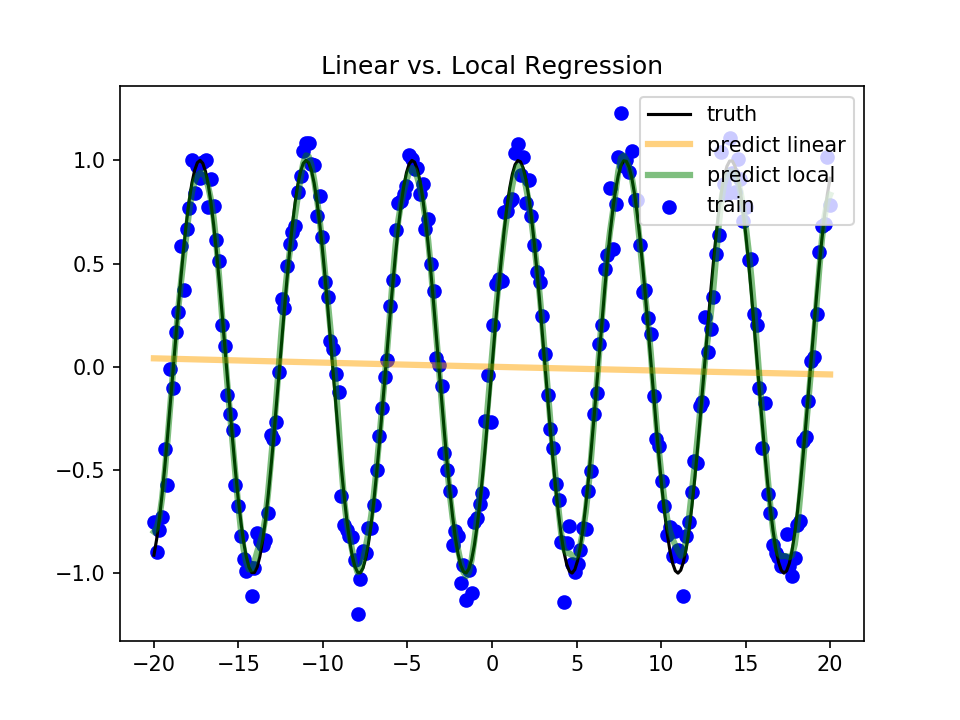

interactive(children=(IntSlider(value=2, description='Degree Linear Regression', max=11, min=1), IntSlider(val…

In [11]:
plt.figure()
@wdg.interact()
def plot_sine(d_lin=wdg.IntSlider(min=1, max=d_max, value=2, description='Degree Linear Regression'),
              d_loc=wdg.IntSlider(min=0, max=1, value=0, description='Degree Local Regression')):
    plt.cla()
    plt.scatter(x, y, color='b', label='train')
    plt.plot(x, np.sin(x), color='k', label='truth')
    plt.plot(x, lr_preds[d_lin], color='orange', linewidth=3, label='predict linear', alpha=0.5)
    plt.plot(x, locreg_preds[d_loc], color='g', linewidth=3, label='predict local', alpha=0.5)
    plt.legend()
    plt.title('Linear vs. Local Regression')
    plt.show()
    print("Score Linear Regression: %f" % lr_scores[d_lin])
    print("Score Local Regression: %f" % locreg_scores[d_loc])

## Example 4: Multivariate Sines

We now illustrate that local regression also works in higher dimensions. In this example, we consider the function $f(x_1, x_2) = \sin(x_1) \sin(x_2)$.

In [12]:
n=20
x1 = np.linspace(-5,5,n)
x2 = np.linspace(-5,5,n)
e = np.random.normal(0, 0.01, (n, n))
y = np.array([[np.sin(xx1)*np.sin(xx2) for xx1 in x1] for xx2 in x2])
y = y + e
x1, x2 = np.meshgrid(x1, x2)
X = np.array(list(zip(x1.flatten(), x2.flatten())))

In [13]:
%%time
locreg3d = LocalRegression(degree=0).fit(X, y.flatten())
y_pred = locreg3d.predict(X, method='qr')

Wall time: 1.44 s


<IPython.core.display.Javascript object>


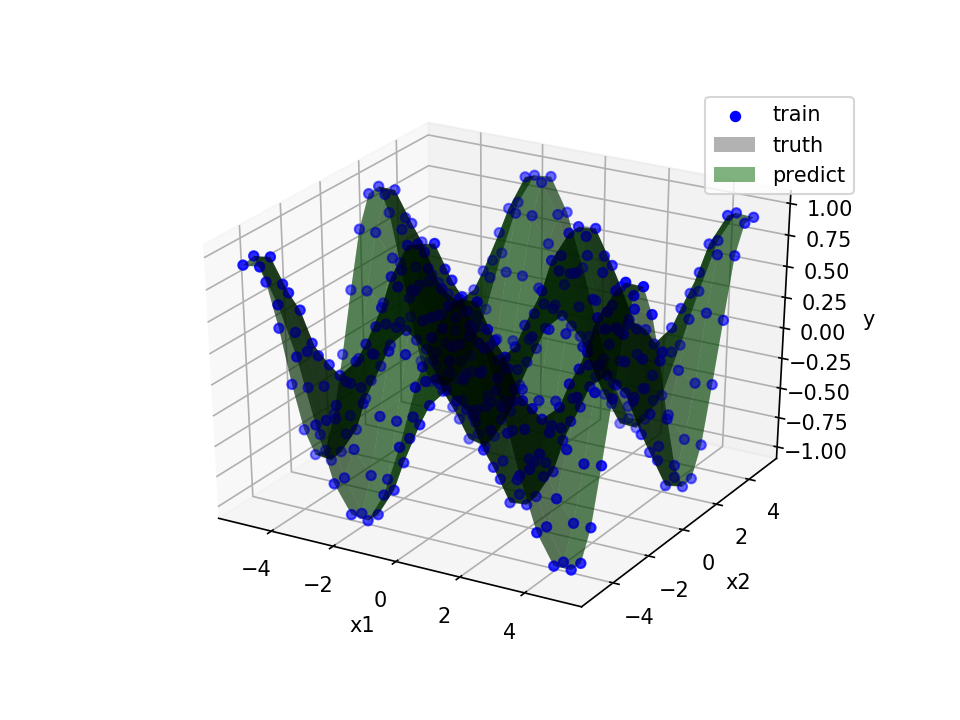

In [14]:
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x1, x2, y, color='b', label='train')
surf = ax.plot_surface(x1, x2, y, color='k', label='truth', alpha=0.3)
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
surf = ax.plot_surface(x1, x2, y_pred.reshape(n, n), color='g', label='predict', alpha=0.5)
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.legend()
plt.show()

In [15]:
locreg3d.score(X, y.flatten())

0.9999769805807223